In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime as dt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2023-01-24 23:21:20.146215: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-24 23:21:21.079292: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/francesco/Downloads/cuda/lib64:/usr/local/cuda-11.2/lib64
2023-01-24 23:21:21.079372: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/francesco/Downloads/cuda/lib64:/usr/local/cuda-11.2/lib64
20

### Load data and flatten

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape)

(60000, 28, 28)


True label: 3


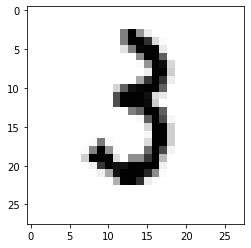

In [3]:
index = 1234
print('True label: {}'.format(y_train[index]) )
plt.imshow(x_train[index], cmap='Greys')
plt.show()

In [4]:
x_train = x_train.reshape(x_train.shape[0], 28*28).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28*28).astype('float32')

x_train = x_train/255
x_test = x_test/255

print('Final shape of input tensor {}'.format(x_train.shape))


Final shape of input tensor (60000, 784)


### Tensorflow Dataset

In [5]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.d1 = tf.keras.layers.Dense(64, activation="relu")
        self.d2 = tf.keras.layers.Dense(32, activation="relu")
        self.d3 = tf.keras.layers.Dense(10, activation=None)
    
    def call(self, x):
        x = self.d1(x)
        x = self.d2(x)
        return self.d3(x)

# Create an instance of the model
model = MyModel()

# Loss and optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Monitoring metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


2023-01-24 23:21:22.893653: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-24 23:21:22.893693: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: francesco-15IMH05
2023-01-24 23:21:22.893701: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: francesco-15IMH05
2023-01-24 23:21:22.893804: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.161.3
2023-01-24 23:21:22.893833: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.161.3
2023-01-24 23:21:22.893839: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.161.3
2023-01-24 23:21:22.894168: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is o

In [6]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, predictions)

    
@tf.function
def test_step(images, labels):
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)
    
    test_loss(t_loss)
    test_accuracy(labels, predictions)


In [7]:
EPOCHS = 50
BATCH_SIZE = 128

In [8]:

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for i in range(0, len(x_train), BATCH_SIZE):
        train_step(x_train[i:i+BATCH_SIZE], y_train[i:i+BATCH_SIZE])
    
    for i in range(0, len(x_test), BATCH_SIZE):
        test_step(x_test, y_test)
    
    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {round(train_loss.result().numpy(), 4)}, '
        f'Accuracy: {round(train_accuracy.result().numpy() * 100, 4)}, '
        f'Test Loss: {round(test_loss.result().numpy(), 4)}, '
        f'Test Accuracy: {round(test_accuracy.result().numpy() * 100, 4)}'
    )


Epoch 1, Loss: 0.4424000084400177, Accuracy: 87.5867, Test Loss: 0.2370000034570694, Test Accuracy: 93.08
Epoch 2, Loss: 0.19930000603199005, Accuracy: 94.22, Test Loss: 0.17960000038146973, Test Accuracy: 94.6
Epoch 3, Loss: 0.15240000188350677, Accuracy: 95.505, Test Loss: 0.15929999947547913, Test Accuracy: 95.15
Epoch 4, Loss: 0.1234000027179718, Accuracy: 96.3133, Test Loss: 0.14659999310970306, Test Accuracy: 95.59
Epoch 5, Loss: 0.10289999842643738, Accuracy: 96.9383, Test Loss: 0.1387999951839447, Test Accuracy: 95.82
Epoch 6, Loss: 0.08789999783039093, Accuracy: 97.3967, Test Loss: 0.12939999997615814, Test Accuracy: 96.04
Epoch 7, Loss: 0.07599999755620956, Accuracy: 97.76, Test Loss: 0.12399999797344208, Test Accuracy: 96.19
Epoch 8, Loss: 0.066600002348423, Accuracy: 98.04, Test Loss: 0.11919999867677689, Test Accuracy: 96.3
Epoch 9, Loss: 0.05860000103712082, Accuracy: 98.26, Test Loss: 0.11309999972581863, Test Accuracy: 96.53
Epoch 10, Loss: 0.051899999380111694, Accurac